In [45]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import clear_output
from scipy.interpolate import interp1d
from datetime import datetime
import os

import numpy as np
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
tfd = tfp.distributions

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten

Num GPUs Available:  1


In [46]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [47]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

In [48]:
# filter & duplicate drop from bayesian_nn
z_max = 2.5
filt = (photozdata['specz_redshift'] < z_max)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 100)\
&(photozdata['r_cmodel_mag'] < 100)\
&(photozdata['i_cmodel_mag'] < 100)\
&(photozdata['z_cmodel_mag'] < 100)\
&(photozdata['y_cmodel_mag'] < 100)\
&(photozdata['specz_flag_homogeneous'] == True)
photozdata.drop_duplicates(subset=['object_id'])
photozdata_subset = photozdata[filt]

In [49]:
photozdata.columns

Index(['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'],
      dtype='object')

In [50]:
photozdata_trainset, photozdata_testset = train_test_split(photozdata_subset, test_size=0.2) # Already randomized

In [51]:
photozdata_trainset.to_csv('/mnt/data/HSC/3_model_comparison/training_'+str(z_max)+'_v2.csv')
photozdata_testset.to_csv('/mnt/data/HSC/3_model_comparison/testing_'+str(z_max)+'_v2.csv')

In [52]:
train_array = np.asarray(photozdata_trainset)

In [53]:
n = len(train_array)

In [54]:
train_sorted = sorted(train_array, key=lambda x: x[2])

In [55]:
train_sorted[0]

array([41601547150321034, 9.99999975e-06, 0.0100999996, 16.9960003,
       'SDSS-DR12-1237656906348626261', 345.33543, -0.925957, True,
       345.33555992089055, -0.9259759774764964,
       '(199519.6875, -52210.6796875, -3333.368408203125)', 94590303,
       22.2296257, 21.982687, 22.1828537, 23.84021, 23.0793934,
       0.00695806509, 0.00607395219, 0.00986235403, 0.0989359617,
       0.113840707], dtype=object)

In [56]:
nstrata = 4
stratas = []
cur = z_max/nstrata
pre = 0
for i in range(0,n):
    if train_sorted[i][2] >= cur:
        stratas.append(train_sorted[pre:i])
        pre = i
        cur += z_max/nstrata
    if i == n - 1:
        stratas.append(train_sorted[pre:i])
strata_lengths = []
for i in range(0,nstrata):
    random.shuffle(stratas[i])
    strata_lengths.append(len(stratas[i]))

In [57]:
nnetwork = 8

In [58]:
print(strata_lengths)

[157355, 51062, 8295, 7425]


In [59]:
# Fix total

sample_array = [1, 1, 1, 1]
training_set_size = 4*min(strata_lengths)

In [60]:
training_data = []

min_array = [int(training_set_size/sum(sample_array))] * nstrata
sample_size_array = [i*j for i,j in zip(sample_array, min_array)]

In [ ]:
# Fix Bottom Strata Size

sample_array = [1, 1, 1, 1]

In [ ]:
training_data = []

min_array = [min(strata_lengths)] * nstrata
sample_size_array = [i*j for i,j in zip(sample_array, min_array)]

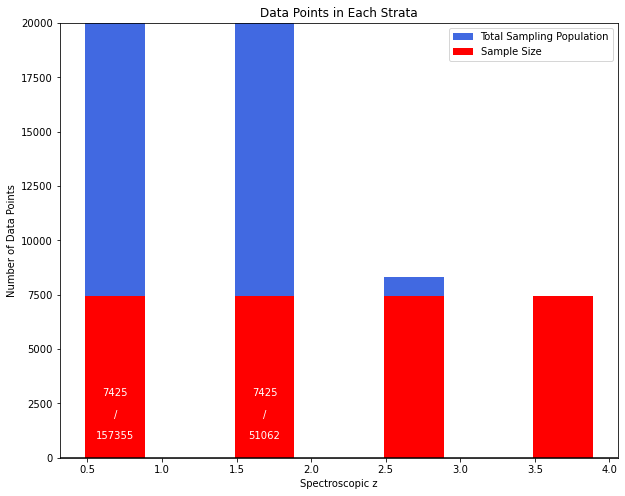

In [61]:
# Plot
z_ranges = [1, 2, 3, 4]
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 10})
ax = plt.subplot(111)
ax.bar([i-(z_max/nstrata/2) for i in z_ranges], strata_lengths, width = 0.4, color = 'royalblue', label = 'Total Sampling Population')
ax.bar([i-(z_max/nstrata/2) for i in z_ranges], sample_size_array, width = 0.4, color = 'red', label = 'Sample Size')

plt.title('Data Points in Each Strata')
plt.xlabel('Spectroscopic z')
plt.ylabel('Number of Data Points')
ylim = 20000
plt.ylim([0,ylim])
plt.text(z_ranges[0]-(z_max/nstrata/2), 1*ylim/20, str(strata_lengths[0]), color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 1*ylim/20, str(strata_lengths[1]), color = 'white', ha='center', va='center')
plt.text(z_ranges[0]-(z_max/nstrata/2), 2*ylim/20, "/", color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 2*ylim/20, "/", color = 'white', ha='center', va='center')
plt.text(z_ranges[0]-(z_max/nstrata/2), 3*ylim/20, str(sample_size_array[0]), color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 3*ylim/20, str(sample_size_array[1]), color = 'white', ha='center', va='center')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [62]:
# Sampling training data from each strata

for i in range(0, nnetwork):
    sampled = random.sample(stratas[0][0:strata_lengths[0]], sample_size_array[0])
    training_data_bin = sampled
    for j in range(1, nstrata):
        sampled = random.sample(stratas[j][0:strata_lengths[j]], sample_size_array[j])
        training_data_bin = np.concatenate((training_data_bin, sampled), axis=0)
    training_data.append(training_data_bin)

In [63]:
for i in range(1, nnetwork + 1):
    df = pd.DataFrame(training_data[i - 1], columns=['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'])
    df.to_csv('/mnt/data/HSC/3_model_comparison/training_set_'+str(z_max)+'_'+str(sample_array)+'#'+str(i)+'.csv')

In [64]:
training_data_control = []
for i in range(0, nnetwork):
    sampled = random.sample(list(train_array), training_set_size)
    training_data_control.append(sampled)

In [65]:
for i in range(1, nnetwork + 1):
    df = pd.DataFrame(training_data[i - 1], columns=['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'])
    df.to_csv('/mnt/data/HSC/3_model_comparison/training_set_'+str(z_max)+'_control#'+str(i)+'.csv')

In [66]:
# END